## 018 Model craving as a binomial (single subject)

Date: 03.Aug.2022

### Purpose

Predict craving as a binomial variable since ratings are from 0-50.

### Outline of Plan

1. Copied from NB#013, passive prototype and models only.
2. Rewrite the cravings to be non-normed, and the predictions should be probabilities of success from 0-1, 50 draws from a binomial distribution.
3. See if the NUTS sampler can be rescued, or if a different joint sampler works.

### What we did in this notebook

1. Changed the threshold to accuracy $\ge$ 50%. Keep it at this threshold from now on.
2. With the new pid_list, subject 8 is the one to try out.
3. Binomial passive models tested against each other.
   1. 0-step, 1-step mean, 1-step sep, 2-step mean, 2-step sep
4. As expected, the WAIC comparisons for 'like', the decision models, are very similar
5. Promising differences between 'craving_like', craving models. Visualization of craving predictions look very promising too.
6. In NB#019, need to compare binomial and gaussian craving models directly to each other.
7. Grab the plotting utils from here...

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
from scipy import stats
import time

from abc import ABC, abstractmethod

from sys import path
import os
from IPython.display import clear_output

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [3]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.50) & 
    (df_summary['Other Accuracy']>0.50)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
print(pid_list.shape)
longform

(36,)


,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## (Normed) Retrospective prototype class

Assumptions:
1. Both non-normed and normed cravings are calculated and stored
2. Craving inds are calculated
3. Craving means and st. dev. are calculated
4. Beta is the first variable specified, only one beta, and is a required argument
5. Non-sequences in aesara loop DO NOT include beta
6. Sigma in craving_lik equals 1
7. Normed craving retrieved in fit function
8. MAJOR DIFF: 7 rows in aesara loop, Q[left], Q[right], pred_craving, Q[t-1], Q[t-2], PE[t-1], PE[t-2]

In [4]:
class RetroPrototype(ABC):
    def __init__(self, longform, summary, project_dir):
        self.name = None        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    @abstractmethod
    def update_Q(self, a, r, Qs, *args):
        pass

    def right_action_probs(self, actions, rewards, beta, *args):
        # Note that the first parameter is always the sample_beta, it is a required argument
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        # 0 - Q[left]
        # 1 - Q[right]
        # 2 - pred_craving
        # 3 - Q[t-1]
        # 4 - Q[t-2]
        # 5 - PE[t-1]
        # 6 - PE[t-2]
        loopvals =  at.zeros((7,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        t_pred_craving = pm.invlogit(loopvals[:, 2])

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  t_pred_craving
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        # Beta must be returned first!
        pass

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Binomial('craving_like', n=50, p=craving_pred[self.craving_inds-1], observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid] = pm.sample()
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

## Inheritance models (EVRPE only)

### RW Models

In [5]:
class Retro0step_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Retro0step_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two

In [6]:
class Retro1step_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Retro1step_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))

        ## Calculate predicted craving - ONE STEP (Retro1) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * (Qs[a]+Qs[3])/2 + w2 * (pe+Qs[5])/2)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two

In [7]:
class Retro1step_Sep_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Retro1step_Sep_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*pe + w4*Qs[5]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four

In [8]:
class Retro2step_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Retro2step_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * (Qs[a]+Qs[3]+Qs[4])/3 + w2 * (pe+Qs[5]+Qs[6])/3)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two

In [9]:
class Retro2step_Sep_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Retro2step_Sep_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six

## Fit models

In [17]:
class BatchFit(object):
    def __init__(self, model_list, longform, df_summary, project_dir):
        self.models = {}
        for model_name in model_list:
            self.models[model_name] = eval(f'{model_name}(longform, df_summary, project_dir)')
        self.longform = longform
        self.df_summary = df_summary
        self.project_dir = project_dir
    
    def fit(self, pid_num, block, jupyter=False):
        for model_name in self.models:
            if jupyter:
                clear_output(wait=True)
            print(f'Fitting {model_name}: PID - {pid_num}, Block - {block}')
            self.models[model_name].fit(pid_num, block)
    
    def join(self, batch):
        for model_name in batch.models:
            if model_name not in self.models:
                self.models[model_name] = batch.models[model_name]
            else:
                print(f'Model {model_name} already exists in this batch')
                
    

In [18]:
batchfit = BatchFit(
    [
        'Retro0step_RW_EVRPE',
        'Retro1step_RW_EVRPE',
        'Retro1step_Sep_RW_EVRPE',
        'Retro2step_RW_EVRPE',
        'Retro2step_Sep_RW_EVRPE'
    ],
    longform,
    df_summary,
    project_dir
)

In [158]:
batchfit.fit(8, 'other', jupyter=True)

Fitting Retro2step_Sep_RW_EVRPE: PID - 8, Block - other


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [untr_alpha]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]
>Metropolis: [weight_three]
>Metropolis: [weight_four]
>Metropolis: [weight_five]
>Metropolis: [weight_six]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 113 seconds.


In [102]:
for model_name, model in batchfit.models.items():
    model.traces['other'][pid_list[7]].to_netcdf(f'/Users/kulkarnik/LocalProjects/SlotsTasks/bayesian_models/slotscraving/exploration/18_traces/{model_name}.nc')

## Plotting utils

In [10]:
def plot_ppc(batchfit, pid_num, block):
    n_rows = np.max([int(np.ceil(len(batchfit.models)/3)), 2])
    print(n_rows)
    fig, ax = plt.subplots(ncols=3, nrows=n_rows, figsize=(18,n_rows*2), facecolor='w', edgecolor='k')
    row_ind = 0
    col_ind = 0
    for model_name in batchfit.models:
        model = batchfit.models[model_name]
        posterior_pred = model.traces[block][model.pid_list[pid_num]].posterior_predictive.like[0]
        for i, row in enumerate(posterior_pred):
            sns.scatterplot(x=np.arange(len(row)), y=row, color='blue', alpha=0.01, ax=ax[row_ind, col_ind])
            if i > 50:
                break
        # az.plot_hdi(x=np.arange(posterior_pred.shape[1]), y=posterior_pred, hdi_prob=0.60, ax=ax[row_ind, col_ind])
        pid_act = model.longform[(model.longform['PID']==model.pid_list[pid_num]) & (model.longform['Type']==block)]['Action'].values
        sns.scatterplot(x=np.arange(len(pid_act)), y=pid_act+0.1, color='red', ax=ax[row_ind, col_ind])
        ax[row_ind, col_ind].set_title(f'{model_name}')
        if col_ind == 2:
            col_ind = 0
            row_ind += 1
        else:
            col_ind += 1
    plt.tight_layout()
    plt.close()
    return fig

In [11]:
def plot_true_choices(batchfit, pid_num, block):
    b = 0 if block=='money' else 1
    samp_model = batchfit.models[list(batchfit.models.keys())[0]]
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4), facecolor='w', edgecolor='k')
    pid_act = samp_model.longform[(samp_model.longform['PID']==samp_model.pid_list[pid_num]) & (samp_model.longform['Type']==block)]['Action'].values
    sns.scatterplot(x=np.arange(len(pid_act)), y=0.5*pid_act+0.25, s=100, color='red', ax=ax)
    ax.set_title(f'True choices')
    for rev in [12, 24, 36, 48]:
        ax.vlines(rev, 0, 1, color='black', linestyle='--')
    ax2 = ax.twinx()
    ax2.plot(samp_model.craving_inds, samp_model.cravings[b, pid_num], color='red', alpha=0.4)
    plt.tight_layout()
    plt.close()
    return fig

In [12]:
def plot_ppc_craving(batchfit, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
    model_names = list(batchfit.models.keys())
    samp_model = batchfit.models[model_names[0]]
    sns.lineplot(
        x=np.arange(samp_model.cravings[b, pid_num].shape[0]),
        y=samp_model.cravings[b, pid_num],
        label='True craving',
        color='black'
    )
    for model_name in batchfit.models:
        model = batchfit.models[model_name]
        sns.lineplot(
            x=np.arange(len(model.cravings[b, pid_num])),
            y=model.traces[block][model.pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
            label=f'{model_name}'
        )
    plt.tight_layout()
    plt.close()
    return fig


In [13]:
def plot_indivsub_model_comp(batchfit, pid_num, block, ic='waic', var_name='like'):
    model_comp = az.compare({
        k: v.traces[block][v.pid_list[pid_num]] for k, v in batchfit.models.items()
    },
    ic=ic,
    var_name=var_name)
    display(model_comp)
    az.plot_compare(model_comp,insample_dev=True, figsize=(12,10))


## Plot

In [14]:
pid_num = 8

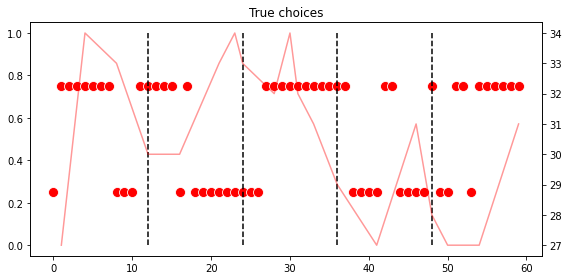

In [23]:
plot_true_choices(batchfit, pid_num=12, block='other')

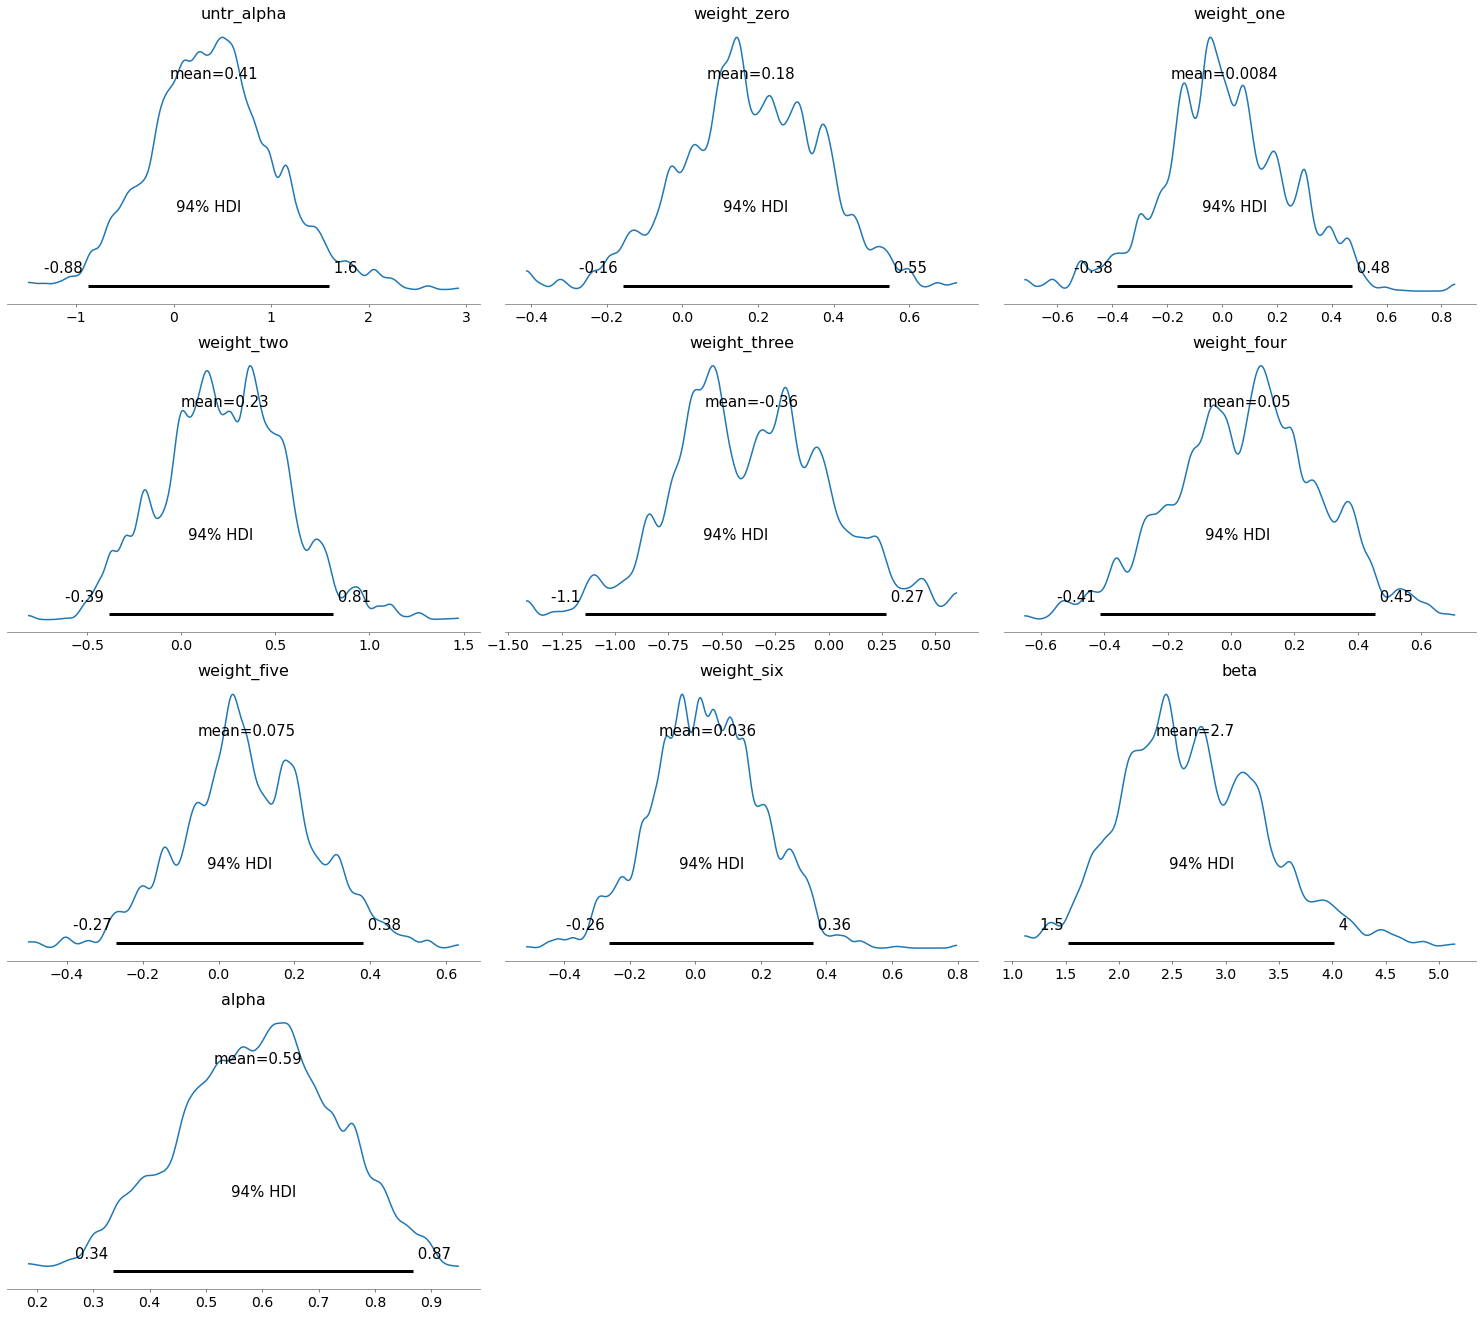

In [168]:
# az.plot_trace(
#     batchfit.models['Retro2step_Sep_RW_EVRPE'].traces['other'][pid_list[pid_num]], 
#     var_names=['beta', 'alpha', 'weight_zero', 'weight_one', 'weight_two'], combined=True
# )
az.plot_posterior(
    batchfit.models['Retro2step_Sep_RW_EVRPE'].traces['other'][pid_list[pid_num]]
)
plt.tight_layout()

2


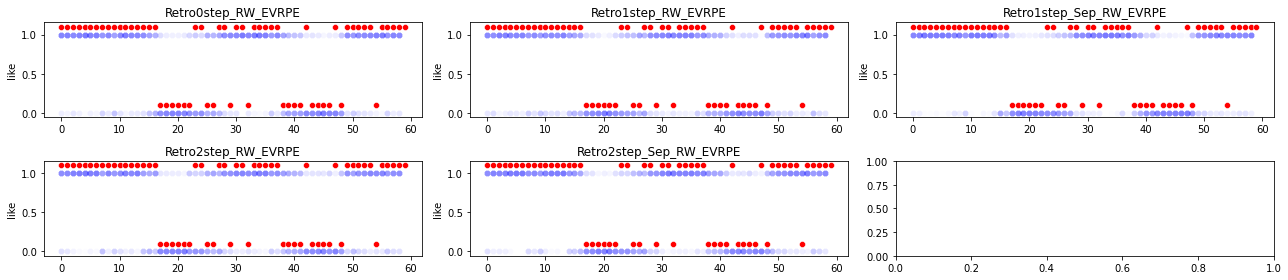

In [162]:
plot_ppc(batchfit, pid_num, 'other')

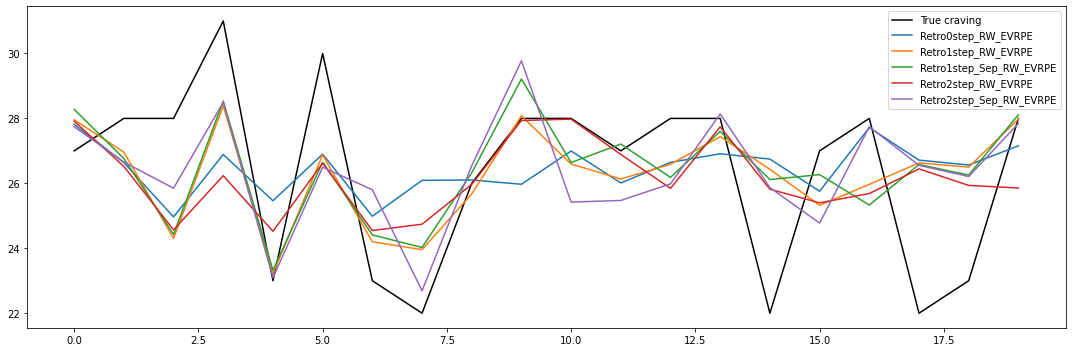

In [163]:
plot_ppc_craving(batchfit, pid_num, 'other')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Retro1step_RW_EVRPE,0,-49.819594,1.211508,0.000000,1.000000e+00,1.278778,0.000000,False,log
Retro2step_RW_EVRPE,1,-50.754158,1.418672,0.934564,1.179612e-16,1.212180,0.579634,False,log
Retro1step_Sep_RW_EVRPE,2,-51.297309,2.180194,1.477715,0.000000e+00,1.153547,0.573557,False,log
Retro0step_RW_EVRPE,3,-51.429052,1.676883,1.609458,0.000000e+00,1.390725,0.607923,False,log
Retro2step_Sep_RW_EVRPE,4,-52.473683,2.970575,2.654089,0.000000e+00,1.023221,0.869283,False,log


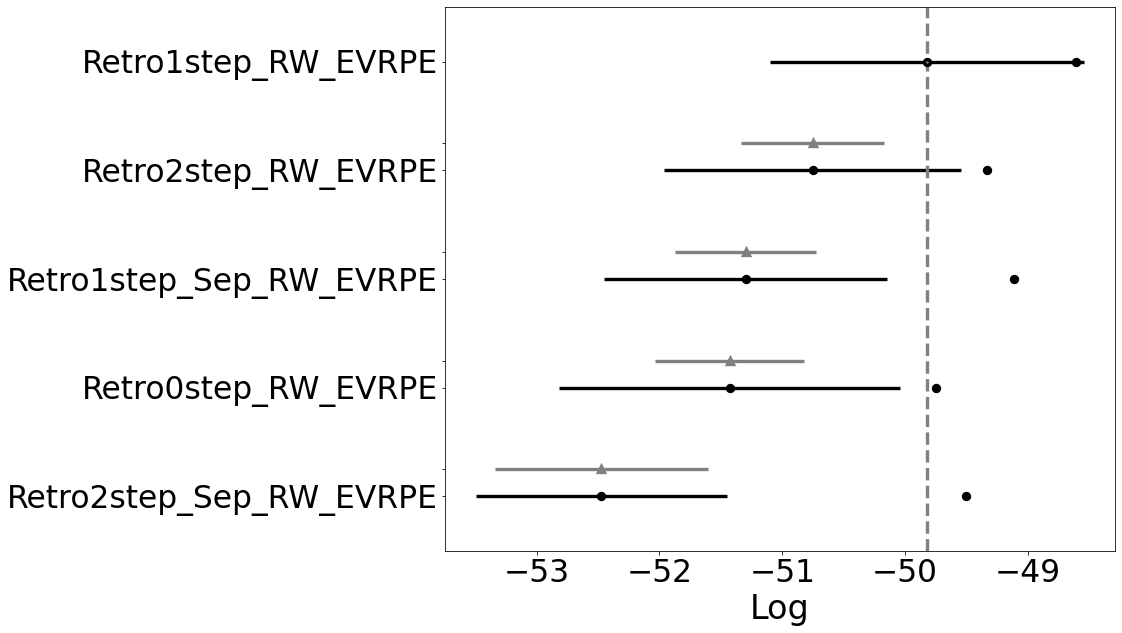

In [169]:
plot_indivsub_model_comp(batchfit, pid_num, 'other', var_name='craving_like')